### Create data

In [ ]:
import math 
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]


def train_test_split(X,y, train_frac=0.8):
    N = int(X.shape[0]*train_frac)
    X_train = X[:N] 
    X_val = X[N:]
    y_train = y[:N]
    y_val =  y[N:]
    return X_train, y_train, X_val, y_val

In [ ]:
n = 100
p = 500
rng = np.random
sparsity = 0.75
X, y, beta = simulate_data(n,p,rng,sparsity = sparsity)
X_train, y_train, X_val, y_val = train_test_split(X,y)


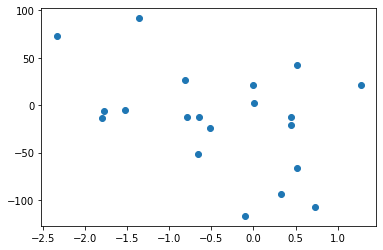

In [ ]:
plt.scatter(X_val[:,0],y_val)

# Task 1: simulate 


#### Create lasso model

In [ ]:
n_folds = 5

lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
score = lassoCV.score(X,y)

alpha = lassoCV.alpha_
print(f"alpha_: {alpha}")
mse = lassoCV.mse_path_

alpha_: 17.079932344997815


#### Find alpha_1se

In [ ]:



cv_mean = np.mean(lassoCV.mse_path_, axis=1)
cv_std = np.std(lassoCV.mse_path_, axis=1)
idx_min_mean = np.argmin(cv_mean)
idx_alpha = np.where(
    (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
    (cv_mean >= cv_mean[idx_min_mean])
)[0][0]
alpha_1se = lassoCV.alphas_[idx_alpha]
print(f"alpha_1se: {alpha_1se}")


alpha_1se: 22.578665379868482


#### Test alpha

In [ ]:
lasso = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train)
mse_train_min = sklearn.metrics.mean_squared_error(lasso.predict(X_train), y_train)
mse_val_min = sklearn.metrics.mean_squared_error(lasso.predict(X_val), y_val)

print(f"MSE train alpha_min: {mse_train_min}")
print(f"MSE validation alpha_min: {mse_val_min}")

MSE train alpha_min: 3099.0974374128323
MSE validation alpha_min: 2811.3301675147786


#### Test alpha_1se

In [ ]:
lasso_1se = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train)
mse_train_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_train), y_train)
mse_val_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_val), y_val)

print(f"MSE train alpha_1se: {mse_train_1se}")
print(f"MSE validation alpha_1se: {mse_val_1se}")

MSE train alpha_1se: 3566.9617900124563
MSE validation alpha_1se: 2831.1064064386273


#### Comparison different parameters for dataset

In [ ]:
alpha_1se_mse_val = []
alpha_min_mse_val = []
alpha_1se_mse_train = []
alpha_min_mse_train = []
n = [200, 400, 600, 800]
sparsity = [0.8,0.85, 0.9, 0.95]
mse_1se_values = np.zeros((len(n), len(sparsity)))
mse_min_values = np.zeros((len(n), len(sparsity)))

mse_1se_values_train = np.zeros((len(n), len(sparsity)))
mse_min_values_train = np.zeros((len(n), len(sparsity)))

for i in range(4):
    for t in range(4):

        p = 1000
        rng = np.random

        X, y, beta = simulate_data(n[i],p,rng,sparsity = sparsity[t])
        X_train, y_train, X_val, y_val = train_test_split(X,y)

        lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
        alpha = lassoCV.alpha_
        cv_mean = np.mean(lassoCV.mse_path_, axis=1)
        cv_std = np.std(lassoCV.mse_path_, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
        (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
        (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
        alpha_1se = lassoCV.alphas_[idx_alpha]
        
        
        lasso = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train)
        lasso_1se = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train)

        mse_train_min = sklearn.metrics.mean_squared_error(lasso.predict(X_train), y_train)
        mse_train_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_train), y_train)

        mse_val_min = sklearn.metrics.mean_squared_error(lasso.predict(X_val), y_val)
        mse_val_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_val), y_val)

        alpha_min_mse_val.append(mse_val_min)
        alpha_1se_mse_val.append(mse_val_1se)
        alpha_min_mse_train.append(mse_train_min)
        alpha_1se_mse_train.append(mse_train_1se)

        mse_1se_values[i,t] = mse_val_1se
        mse_min_values[i,t] = mse_val_min

        mse_1se_values_train[i,t] = mse_train_1se
        mse_min_values_train[i,t] = mse_train_min





"""  
plt.subplot(1,2,1)
plt.plot(alpha_1se_mse_val, label = "Alpha_1se")
plt.plot(alpha_min_mse_val,label = "Alpha_min")
plt.subplot(1,2,2)
plt.plot(alpha_1se_mse_train,label = "Alpha_1se")
plt.plot(alpha_min_mse_train,label = "Alpha_min")
"""

'  \nplt.subplot(1,2,1)\nplt.plot(alpha_1se_mse_val, label = "Alpha_1se")\nplt.plot(alpha_min_mse_val,label = "Alpha_min")\nplt.subplot(1,2,2)\nplt.plot(alpha_1se_mse_train,label = "Alpha_1se")\nplt.plot(alpha_min_mse_train,label = "Alpha_min")\n'

[[4274.27782322 4056.55057121 1996.20081662  870.55084268]
 [5474.47250485 3606.73789951 2171.49896302  556.99744734]
 [3178.67558206 2287.48272603 1712.51553613  359.47489102]
 [3116.66139771 2439.38091254 1074.27688136  308.69528655]]
[[4016.62361322 3800.11166304 1953.69451172  816.70911613]
 [4836.61928788 3504.06515712 2166.88036606  455.99166886]
 [2929.35014729 2054.90234702 1554.65096591  329.19321711]
 [2609.0374418  2164.71754436  940.57052323  300.06199885]]


<AxesSubplot:>

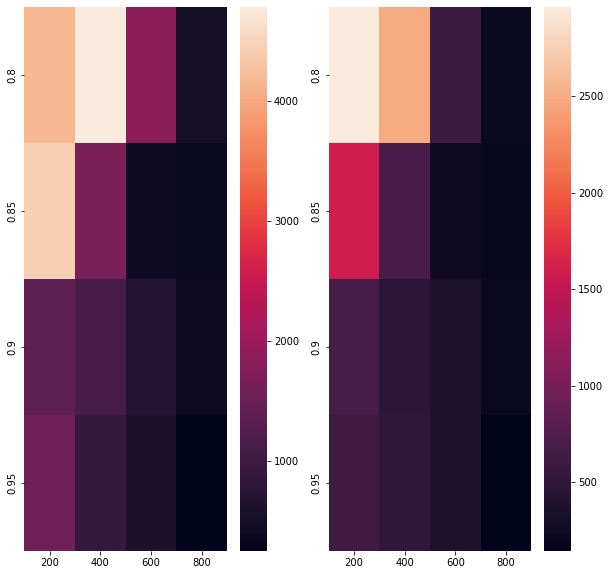

In [ ]:
print(mse_1se_values)
print(mse_min_values)
plt.figure(figsize=(10,10))

plt.subplot(121)
sns.heatmap(mse_1se_values_train, xticklabels=n, yticklabels=sparsity)
plt.subplot(122)
sns.heatmap(mse_min_values_train, xticklabels=n, yticklabels=sparsity)

ValueError: 'higher right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

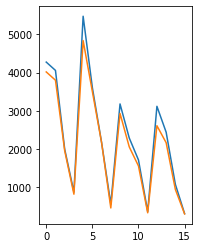

In [ ]:
plt.subplot(1,2,1)
plt.plot(alpha_1se_mse_val, label = "Alpha_1se")
plt.plot(alpha_min_mse_val,label = "Alpha_min")
plt.legend(loc ="higher right")
plt.subplot(1,2,2)
plt.plot(alpha_1se_mse_train,label = "Alpha_1se")
plt.plot(alpha_min_mse_train,label = "Alpha_min")
plt.legend(loc ="higher right")
plt.show()

#### Comparisson same parameters for datasets

In [ ]:
alpha_1se_mse_val = []
alpha_min_mse_val = []

alpha_1se_mse_train = []
alpha_min_mse_train = []

for i in range(10):
    n = 500
    p = 1000
    rng = np.random
    sparsity = 0.8
    X, y, beta = simulate_data(n,p,rng,sparsity = sparsity)
    X_train, y_train, X_val, y_val = train_test_split(X,y)

    lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
    alpha = lassoCV.alpha_
    cv_mean = np.mean(lassoCV.mse_path_, axis=1)
    cv_std = np.std(lassoCV.mse_path_, axis=1)
    idx_min_mean = np.argmin(cv_mean)
    idx_alpha = np.where(
    (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
    (cv_mean >= cv_mean[idx_min_mean])
    )[0][0]
    alpha_1se = lassoCV.alphas_[idx_alpha]
        
        
    lasso = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train)
    lasso_1se = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train)

    mse_val_min = sklearn.metrics.mean_squared_error(lasso.predict(X_val), y_val)
    mse_val_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_val), y_val)

    mse_train_min = sklearn.metrics.mean_squared_error(lasso.predict(X_train), y_train)
    mse_train_1se = sklearn.metrics.mean_squared_error(lasso_1se.predict(X_train), y_train)

    alpha_1se_mse_val.append(mse_val_1se)
    alpha_min_mse_val.append(mse_val_min)

    alpha_1se_mse_train.append(mse_train_1se)
    alpha_min_mse_train.append(mse_train_min)

plt.subplot(121)
plt.plot(alpha_1se_mse_val)
plt.plot(alpha_min_mse_val)

plt.subplot(122)
plt.plot(alpha_1se_mse_train)
plt.plot(alpha_min_mse_train)




KeyboardInterrupt: 

#### Feature selection evaluation

sensitivity_1se: 0.048 , sensitivity_min: 0.264 , specificity_1se: 0.9973333333333333 , specificity_min: 0.8933333333333333
sensitivity_1se: 0.064 , sensitivity_min: 0.128 , specificity_1se: 0.9973333333333333 , specificity_min: 0.9733333333333334
sensitivity_1se: 0.024 , sensitivity_min: 0.12 , specificity_1se: 1.0 , specificity_min: 0.9653333333333334
sensitivity_1se: 0.056 , sensitivity_min: 0.16 , specificity_1se: 0.992 , specificity_min: 0.9546666666666667
sensitivity_1se: 0.128 , sensitivity_min: 0.32 , specificity_1se: 0.9733333333333334 , specificity_min: 0.8853333333333333
sensitivity_1se: 0.168 , sensitivity_min: 0.4 , specificity_1se: 0.9813333333333333 , specificity_min: 0.9146666666666666
sensitivity_1se: 0.072 , sensitivity_min: 0.44 , specificity_1se: 0.992 , specificity_min: 0.7653333333333333
sensitivity_1se: 0.016 , sensitivity_min: 0.16 , specificity_1se: 1.0 , specificity_min: 0.9626666666666667
sensitivity_1se: 0.056 , sensitivity_min: 0.152 , specificity_1se: 0.99

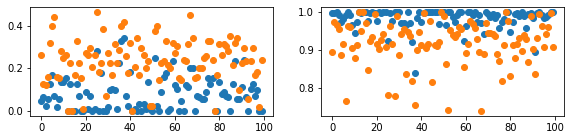

In [ ]:
from collections import Counter
from sklearn.metrics import accuracy_score

sensitivity_1se_values = []
sensitivity_min_values = []

specificity_1se_values = []
specificity_min_values = []

for i in range(100): 
    n = 200
    p = 500
    rng = np.random
    sparsity = 0.75
    X, y, beta = simulate_data(n,p,rng,sparsity = sparsity)
    X_train, y_train, X_val, y_val = train_test_split(X,y)

    n_folds = 5

    lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
    score = lassoCV.score(X,y)

    #Find alpha
    alpha = lassoCV.alpha_

    #Find alpha_1se
    cv_mean = np.mean(lassoCV.mse_path_, axis=1)
    cv_std = np.std(lassoCV.mse_path_, axis=1)
    idx_min_mean = np.argmin(cv_mean)
    idx_alpha = np.where(
        (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
        (cv_mean >= cv_mean[idx_min_mean])
    )[0][0]
    alpha_1se = lassoCV.alphas_[idx_alpha]

    #Retrain model with right alphas
    lasso = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train)
    lasso_1se = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train)

    #0-1 vectors
    beta_est_min = (lasso.coef_ != 0).astype(int)
    beta_est_1se = (lasso_1se.coef_ != 0).astype(int)

    beta = (beta != 0).astype(int)

    sensitivity_1se = sum(beta*beta_est_1se)/ beta.sum()
    sensitivity_min = sum(beta*beta_est_min)/ beta.sum()


    beta_zero = beta == 0
    beta_est_1se_zero = beta_est_1se == 0
    beta_est_min_zero = beta_est_min == 0

    sensitivity_1se = np.sum(beta*beta_est_1se) / np.sum(beta)
    sensitivity_min = np.sum(beta*beta_est_min) / np.sum(beta)
    
    specificity_1se = np.sum(beta_zero*beta_est_1se_zero) / np.sum(beta == 0)
    specificity_min = np.sum(beta_zero*beta_est_min_zero) / np.sum(beta == 0)

    print(f"sensitivity_1se: {sensitivity_1se} , sensitivity_min: {sensitivity_min} , specificity_1se: {specificity_1se} , specificity_min: {specificity_min}")

    sensitivity_1se_values.append(sensitivity_1se) 
    sensitivity_min_values.append(sensitivity_min) 

    specificity_1se_values.append(specificity_1se)
    specificity_min_values.append(specificity_min)

plt.figure(figsize=(20,2))
plt.subplot(141)
plt.scatter(list(range(len(sensitivity_1se_values))),sensitivity_1se_values)
plt.scatter(list(range(len(sensitivity_min_values))),sensitivity_min_values)
plt.subplot(142)
plt.scatter(list(range(len(specificity_1se_values))),specificity_1se_values)
plt.scatter(list(range(len(specificity_min_values))),specificity_min_values)









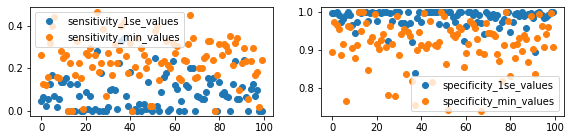

In [ ]:
plt.figure(figsize=(20,2))
plt.subplot(141)
plt.scatter(list(range(len(sensitivity_1se_values))),sensitivity_1se_values, label = "sensitivity_1se_values")
plt.scatter(list(range(len(sensitivity_min_values))),sensitivity_min_values, label = "sensitivity_min_values")
plt.legend(loc ="upper left")
plt.subplot(142)
plt.scatter(list(range(len(specificity_1se_values))),specificity_1se_values, label = "specificity_1se_values")
plt.scatter(list(range(len(specificity_min_values))),specificity_min_values, label = "specificity_min_values")
plt.legend(loc ="lower right")

#### Exploring sensitivity and specificity for diffferent n,p and sparcity 

In [ ]:
from collections import Counter
from sklearn.metrics import accuracy_score



n = [100, 250, 400]
p = 500
rng = np.random
sparsity = [0.75, 0.85, 0.9, 0.95]

sensitivity_1se_values = np.zeros((len(n), len(sparsity)))
sensitivity_min_values = np.zeros((len(n), len(sparsity)))

specificity_1se_values = np.zeros((len(n), len(sparsity)))
specificity_min_values = np.zeros((len(n), len(sparsity)))
for i in range(3): 
    for j in range(4):
        X, y, beta = simulate_data(n[i],p,rng,sparsity = sparsity[j])
        X_train, y_train, X_val, y_val = train_test_split(X,y)

        n_folds = 5

        lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
        score = lassoCV.score(X,y)

        #Find alpha
        alpha = lassoCV.alpha_

        #Find alpha_1se
        cv_mean = np.mean(lassoCV.mse_path_, axis=1)
        cv_std = np.std(lassoCV.mse_path_, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
            (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
            (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
        alpha_1se = lassoCV.alphas_[idx_alpha]

        #Retrain model with right alphas
        lasso = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train)
        lasso_1se = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train)
        #0-1 vectors
        beta_est_min = (lasso.coef_ != 0).astype(int)
        beta_est_1se = (lasso_1se.coef_ != 0).astype(int)

        beta = (beta != 0).astype(int)

        sensitivity_1se = sum(beta*beta_est_1se)/ beta.sum()
        sensitivity_min = sum(beta*beta_est_min)/ beta.sum()


        beta_zero = beta == 0
        beta_est_1se_zero = beta_est_1se == 0
        beta_est_min_zero = beta_est_min == 0

        sensitivity_1se = np.sum(beta*beta_est_1se) / np.sum(beta)
        sensitivity_min = np.sum(beta*beta_est_min) / np.sum(beta)
            
        specificity_1se = np.sum(beta_zero*beta_est_1se_zero) / np.sum(beta == 0)
        specificity_min = np.sum(beta_zero*beta_est_min_zero) / np.sum(beta == 0)

        #print(f"sensitivity_1se: {sensitivity_1se} , sensitivity_min: {sensitivity_min} , specificity_1se: {specificity_1se} , specificity_min: {specificity_min}")

        sensitivity_1se_values[i,j] = sensitivity_1se
        sensitivity_min_values[i,j] = sensitivity_min

        specificity_1se_values[i,j] = specificity_1se
        specificity_min_values[i,j] = specificity_min


<AxesSubplot:>

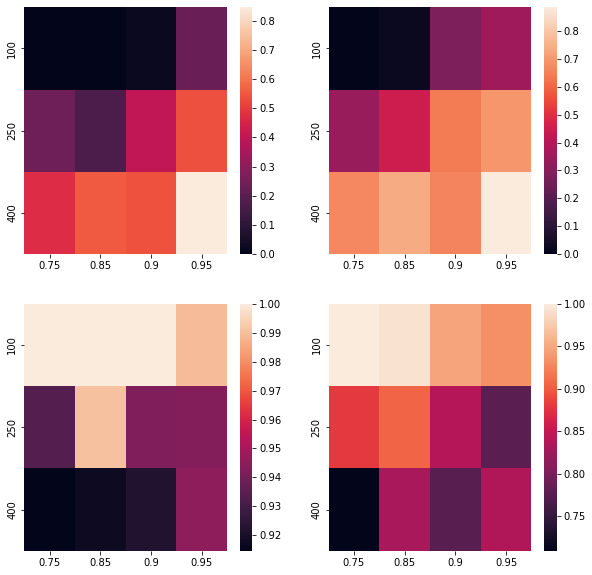

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(221)
sns.heatmap(sensitivity_1se_values, xticklabels=sparsity, yticklabels=n)
plt.subplot(222)
sns.heatmap(sensitivity_min_values, xticklabels=sparsity, yticklabels=n)

plt.subplot(223)
sns.heatmap(specificity_1se_values, xticklabels=sparsity, yticklabels=n)
plt.subplot(224)
sns.heatmap(specificity_min_values, xticklabels=sparsity, yticklabels=n)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f98e27f7-6444-4cf3-8fec-73bc47540f9b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>